# Hands-On Assignment 4

In this assignment, we will introduce you to [scikit-learn](https://scikit-learn.org/stable/index.html) (imported in Python as `sklearn`),
the most ubiquitous machine learning library for Python.
We will use this library to train and interpret a few standard models in machine learning.
Finally, we will recreate a few classic observations in machine learning.

scikit-learn is a large library that contains tools for classification, regression, clustering, feature selection, evaluation, and preprocessing.
We will also refer to "scikit-learn" as "sklearn".
Since Python doesn't like package names with a dash, `sklearn` is what you use to import the library in Python.
It uses a fairly consistent API that lets you swap out components without needing the change your entire infrastructure,
e.g., you can swap out the type of classifier you use without needing to change the rest of your code.
It is so ubiquitous in machine learning that other machine learning libraries will often use the same terminology and methods (which we will discuss later).
In this assignment, we will cover the basics that you need to know to work with sklearn,
but there are many additional resources on the web.
If you need more instruction, we recommend this [text tutorial](https://scikit-learn.org/stable/getting_started.html)
and this [video tutorial](https://www.youtube.com/watch?v=0B5eIE_1vpU).
sklearn also has a very complete [user guide](https://scikit-learn.org/stable/user_guide.html)
and many curated [examples](https://scikit-learn.org/stable/auto_examples/index.html).

The objective of this assignment is for you to learn about:
 - The basic functionality and terminology of sklearn.
 - How to visualize and interpret decision boundaries.
 - How to use simple and effective machine learning models.

### Revisiting Synthetic Covid-19 Data

For this assignment, we will revisit the same data domain we used in HO1 and HO2: the synthetic Covid-19 data.
Except this time we will have access to more information about the patients.
Our task will remain the same, predicting whether a patient has Covid-19.

Load this dataset, included in this repository as `synthetic_covid_data_v2.csv`, using Python, and feel free to explore its content.
Note again that this data is entirely synthetic (because in general, an individual's health care data is strictly regulated).
There may be unrealistic qualities of this dataset.

In [1]:
import matplotlib.pyplot
import pandas
import numpy as np
import sklearn.base
import sklearn.datasets
import sklearn.inspection
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.neighbors
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.tree

# Read data from the given csv file into a Pandas dataframe.
covid_data = pandas.read_csv("synthetic_covid_data_v2.csv", index_col = 0)

# Print column and type information.
covid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   infected              5000 non-null   bool   
 1   symptomatic           5000 non-null   bool   
 2   days_before_symptoms  138 non-null    float64
 3   titer                 5000 non-null   int64  
 4   blood_oxygen          5000 non-null   float64
 5   sex                   5000 non-null   object 
 6   age                   5000 non-null   float64
 7   height                5000 non-null   float64
 8   weight                5000 non-null   float64
dtypes: bool(2), float64(5), int64(1), object(1)
memory usage: 322.3+ KB


First, note that the column 'sex' is encoded as an object, rather than a number.
Upon inspection, we find that this column takes on either 'male' or 'female' values:

In [2]:
# Inspect the first few rows.
covid_data.head()

,infected,symptomatic,days_before_symptoms,titer,blood_oxygen,sex,age,height,weight
id,,,,,,,,,
0,False,False,NaN,0,0.97,male,42.0,167.3,90.9
1,False,False,NaN,0,0.96,male,44.0,193.3,83.6
2,False,False,NaN,26,0.96,other,24.0,181.8,78.2
3,False,False,NaN,0,0.96,female,38.0,170.3,80.8
4,False,False,NaN,0,0.96,female,44.0,172.2,76.4


In [3]:
# Inspect any numeric columns.
covid_data.describe()

,days_before_symptoms,titer,blood_oxygen,age,height,weight
count,138.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000
mean,5.405797,3.21480,0.947228,30.630600,177.32820,81.774620
std,3.877010,8.30552,0.021397,13.859876,10.47455,11.270835
min,0.000000,0.00000,0.800000,1.000000,144.00000,45.000000
25%,2.000000,0.00000,0.930000,20.000000,170.40000,74.100000
50%,5.000000,0.00000,0.950000,30.000000,177.40000,81.400000
75%,9.000000,1.00000,0.960000,41.000000,184.40000,89.300000
max,13.000000,45.00000,1.000000,71.000000,213.00000,135.000000


There is a non-numeric column ("sex") that we need to prepare.

In [4]:
# Determine which categories of sex are in the dataset.
print("Possible values for the sex column: ", sorted(set(covid_data["sex"])))

Possible values for the sex column:  ['female', 'male', 'other', 'prefer not to say']


Let's one-hot encode the "sex" column, just like we did in HO3.
A useful function to use here is [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html),
which can handle basic one-hot encoding for us
(in complex situations you may have to do your own encoding).

In [5]:
one_hot_sex = pandas.get_dummies(covid_data['sex'], prefix = 'sex')
one_hot_sex

,sex_female,sex_male,sex_other,sex_prefer not to say
id,,,,
0,False,True,False,False
1,False,True,False,False
2,False,False,True,False
3,True,False,False,False
4,True,False,False,False
...,...,...,...,...
4995,False,False,False,True
4996,False,True,False,False
4997,False,False,False,True


Now just add it to our main frame and remove the old "sex" column.
Remember, the `axis = 1` is so that we can add columns (`axis = 1`) instead of rows (`axis = 0`).

In [6]:
covid_data = pandas.concat([covid_data, one_hot_sex], axis = 1)
covid_data.pop('sex')
covid_data

,infected,symptomatic,days_before_symptoms,titer,blood_oxygen,age,height,weight,sex_female,sex_male,sex_other,sex_prefer not to say
id,,,,,,,,,,,,
0,False,False,NaN,0,0.97,42.0,167.3,90.9,False,True,False,False
1,False,False,NaN,0,0.96,44.0,193.3,83.6,False,True,False,False
2,False,False,NaN,26,0.96,24.0,181.8,78.2,False,False,True,False
3,False,False,NaN,0,0.96,38.0,170.3,80.8,True,False,False,False
4,False,False,NaN,0,0.96,44.0,172.2,76.4,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,False,NaN,0,0.93,46.0,191.4,104.8,False,False,False,True
4996,False,False,NaN,1,0.93,40.0,183.9,88.9,False,True,False,False
4997,False,False,NaN,0,0.94,53.0,185.1,94.7,False,False,False,True


Now that our data is clean, we can separate out the features and labels.
For features, we are going to focus on the new columns added for this assignment.

In [7]:
# Extract features and labels.
covid_labels = covid_data['infected']
covid_features = covid_data[['titer', 'age', 'height', 'weight', 'blood_oxygen',
                             'sex_female', 'sex_male', 'sex_other', 'sex_prefer not to say']]

covid_features.describe()

,titer,age,height,weight,blood_oxygen
count,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000
mean,3.21480,30.630600,177.32820,81.774620,0.947228
std,8.30552,13.859876,10.47455,11.270835,0.021397
min,0.00000,1.000000,144.00000,45.000000,0.800000
25%,0.00000,20.000000,170.40000,74.100000,0.930000
50%,0.00000,30.000000,177.40000,81.400000,0.950000
75%,1.00000,41.000000,184.40000,89.300000,0.960000
max,45.00000,71.000000,213.00000,135.000000,1.000000


# Part 1: Introducing scikit-learn

scikit-learn (sklearn) is probably the most popular machine learning library for Python.
Therefore, it's the go-to choice for us to use in the course.
In this section, we will introduce you to some of the functionality we will be using from sklearn.

This section will cover using sklearn for:
 - preprocessing data
 - training and using models
 - visualizing model outputs
 - combining processing steps into pipelines

Here are some links you may find useful:
 - [scikit-learn Homepage](https://scikit-learn.org/stable/index.html)
 - [API Documentation](https://scikit-learn.org/stable/modules/classes.html)
 - [Official User Guide](https://scikit-learn.org/stable/user_guide.html)
 - [Official Examples](https://scikit-learn.org/stable/auto_examples/index.html)
 - [Recommended Text Tutorial](https://scikit-learn.org/stable/getting_started.html)
 - [Recommended Video Tutorial](https://www.youtube.com/watch?v=0B5eIE_1vpU)

## Feature Scaling

Even if your data is immaculate and you have already done all the data cleaning steps we saw in HO3,
there are still a few standard transformations that we routinely apply on data to make it more suited for machine learning.
On of those transformations is *feature scaling*.

[Feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) tries to account for different ranges of numbers that occur in different columns.
To see what we mean, let's take a look at our Covid-19 data.

In [8]:
covid_data.describe()

,days_before_symptoms,titer,blood_oxygen,age,height,weight
count,138.000000,5000.00000,5000.000000,5000.000000,5000.00000,5000.000000
mean,5.405797,3.21480,0.947228,30.630600,177.32820,81.774620
std,3.877010,8.30552,0.021397,13.859876,10.47455,11.270835
min,0.000000,0.00000,0.800000,1.000000,144.00000,45.000000
25%,2.000000,0.00000,0.930000,20.000000,170.40000,74.100000
50%,5.000000,0.00000,0.950000,30.000000,177.40000,81.400000
75%,9.000000,1.00000,0.960000,41.000000,184.40000,89.300000
max,13.000000,45.00000,1.000000,71.000000,213.00000,135.000000


We can see our "blood_oxygen" column has values in the range of $[0.80, 1.00]$,
but our "height" column goes from $144$ to $213$.
All of these values makes sense in the context of their own column,
but it can be hard for our machine learning models to understand that just because "blood_oxygen" is $ 1 / 200 $ the value of "height" does not mean it is less important.

To overcome this issue, we can use feature scaling.

There are several different [feature scaling methods available in sklearn](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html)
(and you can always implement your own).
It's important that you consider what method of scaling works best for your specific domain.
Two of the most popular feature scaling methods are:
 - [Min-Max scaling](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)),
    which makes sure that all values are scaled between $0.0$ and $1.0$.
 - [Z-score Normalization](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)) also confusingly called "Standardization",
     which makes the new mean of the data $0.0$ and the variance $1.0$.

The below image shows an example of a two-dimensional dataset being scaled.
On the left, the unscaled features make it look like the X-axis is the only feature that actually matters.
But after being scaled, on the right, we can see that we do actually need to use the Y-axis to properly classify the data.
Aside from making the features easier for our machine learning methods to interpret,
feature scaling also makes it much easier for us to visualize and interpret the data.

<center><img src="sklearn_scaling.png" width="750px"/></center>
<center style='font-size: small'>Image from <a href='https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html'>scikit-learn</a>.</center>

Feature scalers in sklearn are in the family referred to as [transformers](https://scikit-learn.org/stable/glossary.html#term-transformers).
Transformers all have a `fit_transform()` method (sometimes broken out into individual `fit()` and `transform()` methods).
As the name suggests, these classes are all meant for transforming data (usually in preparation for feeding it into a machine learning model).

As a concrete example, look at the [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) class.
It has both a `fit_transform()` and `fit()` & `transform()` methods.
The `fit()` method computes the min and max values of the passed in data,
and the `transform()` method then uses those min/max values to do the actual transformation.
The `fit_transform()` method just combines both steps into one method.
In this simple case, it may seem unnecessary to have both `fit()` and `transform()` methods,
but in more complex cases we may be using other machine learning models to clean to data for our future machine learning models.
In that case, the fitting would be much more complex.

In [9]:
scaler = sklearn.preprocessing.MinMaxScaler()

data = [[1.0], [2.0], [3.0]]
print("Min-Max scaling with data: ", data)
scaler.fit(data)
print(scaler.transform(data))

# We can also use fit_transform().
data = [[100], [200], [300]]
print("Min-Max scaling with data: ", data)
print(scaler.fit_transform(data))

Min-Max scaling with data:  [[1.0], [2.0], [3.0]]
[[0. ]
 [0.5]
 [1. ]]
Min-Max scaling with data:  [[100], [200], [300]]
[[0. ]
 [0.5]
 [1. ]]


Notice how the two different sets of numbers (which are very different in terms of magnitude),
have the same scaled values.

<h3 style="color: darkorange; font-size: x-large";>★ Task 1.A</h3>

Complete the below function which takes a frame of features and a list of columns to work on.
The function should scale the passed in features (using the specified columns)
using a sklearn [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).
The function should return a frame with the scaled data instead of the original data
(column ordering does not matter).

In [10]:
def scale_data(features, columns):
    """
    Scale numeric columns.

    Args:
        features: A pandas DataFrame.
        columns: A list of column names to scale.

    Returns:
        A pandas DataFrame with scaled versions of the specified columns.
    """
    scaler = sklearn.preprocessing.StandardScaler()
    copy = features.copy()
    for name in columns:
        copy.pop(name)
        data = features[[name]]
        copy[name] = scaler.fit_transform(data)
    return copy

print("Scaled Covid-19 features:")
scaled_features = scale_data(covid_features, ['titer', 'age', 'height', 'weight', 'blood_oxygen'])
if (not isinstance(scaled_features, type(NotImplemented))):
    covid_features = scaled_features

scaled_features

Scaled Covid-19 features:


,sex_female,sex_male,sex_other,sex_prefer not to say,titer,age,height,weight,blood_oxygen
id,,,,,,,,,
0,False,True,False,False,-0.387107,0.820392,-0.957483,0.809726,1.064349
1,False,True,False,False,-0.387107,0.964708,1.524972,0.161972,0.596955
2,False,False,True,False,2.743655,-0.478450,0.426963,-0.317188,0.596955
3,True,False,False,False,-0.387107,0.531761,-0.671046,-0.086481,0.596955
4,True,False,False,False,-0.387107,0.964708,-0.489636,-0.476909,0.596955
...,...,...,...,...,...,...,...,...,...
4995,False,False,False,True,-0.387107,1.109024,1.343562,2.043121,-0.805226
4996,False,True,False,False,-0.266693,0.676077,0.627469,0.632260,-0.805226
4997,False,False,False,True,-0.387107,1.614130,0.742044,1.146914,-0.337832


## The Predictor API

In the last section, we used feature scalers which sklearn classifies as "transformers".
Now, we will looks at sklearn [predictors](https://scikit-learn.org/stable/glossary.html#term-predictors).
Predictors all have `fit()` and `predict()` methods (sometimes combined into a `fit_predict()` method).
Predictors encapsulate our core machine learning models: classifiers, regressors, and clusterers.
([classifiers](https://scikit-learn.org/stable/glossary.html#term-classifiers) and [regressors](https://scikit-learn.org/stable/glossary.html#term-regressors)
will also have a `score()` method that will give you a basic numeric score.)

To test out this interface, let's create a [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) classifier.
In the below cell, you can see that we construct a perceptron classifier.
Then, we can call `fit()` on it to fit/train the classifier with our features and labels
(note that we are just playing around with the sklearn API and have not yet split our data into train and test data).
After our classifier is fitted/trained, we can ask it for predictions with the `predict()` method.
We can also use the `score()` method to get an idea of how well the classifier is doing.
In HO2, we discussed different evaluation methods and how important it is to find the proper metric for your problem.
But as we are just exploring the sklearn API, the generic score method (which returns accuracy for classifiers) will work for now.

A question to ask at this point is: "Hey, why did you choose to use a perceptron classifier in this case?".
The answer to that is: "Good question, no real reason, it just works."
This exchange may be a bit silly, but highlights one of sklearn's biggest strengths: its flexibility.
We are currently using a perceptron classifier,
but we can easily swap out the classifier we are using with only changing the line constructing our classifier (and whatever imports we need).
In the code below, try swapping out the perceptron classifier with other classifiers such as
[K-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
or [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)
and see that the code still works.

In [11]:
# Create a classifier instance.
classifier = sklearn.linear_model.Perceptron()

# Train/fit the classifier.
classifier.fit(covid_features, covid_labels)

# Look at the first 20 predictions.
print("First 20 predictions:")
print(classifier.predict(covid_features)[0:20])

# Get a score for the classifier (for classifiers, this score is accuracy).
print("Classifier's score:", classifier.score(covid_features, covid_labels))

First 20 predictions:
[False False False False False False False False False False False False
 False False False False  True False False False]
Classifier's score: 0.9616


## Visualization - Decision Boundaries

As you may have already discussed, many classifiers work by creating a [decision boundary](https://en.wikipedia.org/wiki/Decision_boundary).
Decision boundaries are a line (or curve, plane, etc) that binary classifiers use to split up a feature space.
Data points on one side of the decision boundary are assigned one class, and the other points are assigned the other class.

Visualizing a classifier's decision boundary can help us understand the choices that a classifier is making.
Unfortunately when visualizing decision boundaries we are limited to two or three dimensions,
but that can still be enough to help us understand what our classifier is doing.

sklearn provides some tools like [DecisionBoundaryDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.DecisionBoundaryDisplay.html)
to help visualize decision boundaries.
Below is a function `visualize_decision_boundary()` that let's us see a decision boundary of a trained classifier.

Accuracy:  0.9816


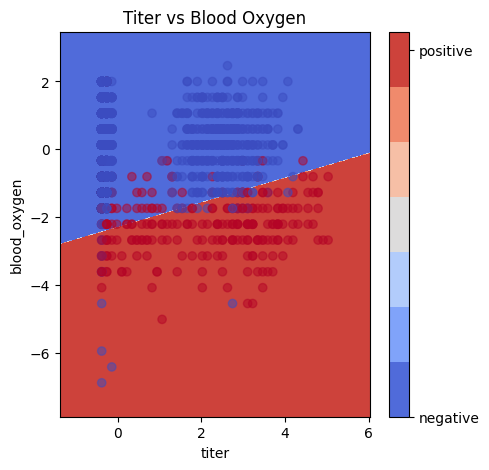

In [12]:
FIGURE_SIZE = 5
FIGURE_RESOLUTION = 500
FIGURE_COLORMAP = 'coolwarm'

def visualize_decision_boundary(classifier, features, labels, title = None):
    """
    Visualize the decision boundary of a trained binary classifier
    using the FIRST TWO columns of the passed in features.
    """

    figure, axis = matplotlib.pyplot.subplots(1, 1, figsize = (FIGURE_SIZE, FIGURE_SIZE))
    axis.set_title(title)

    # Draw the decision boundary.
    decision_boundary = sklearn.inspection.DecisionBoundaryDisplay.from_estimator(
        classifier, features,
        response_method = "predict", ax = axis,
        xlabel = features.columns[0], ylabel = features.columns[1],
        cmap = FIGURE_COLORMAP, grid_resolution = FIGURE_RESOLUTION
    )

    # Also display the data points.
    axis.scatter(
        features[features.columns[0]], features[features.columns[1]],
        c = labels, cmap = FIGURE_COLORMAP, alpha = 0.5,
    )

    # Add a legend for the colors.
    colorbar = figure.colorbar(decision_boundary.surface_, ax = axis, ticks = [0, 1])
    colorbar.ax.set_yticklabels(["negative", "positive"])

    return axis

# Make a classifier we want to use.
classifier = sklearn.linear_model.LogisticRegression()

# Pick the two features we want to see.
two_features = covid_features[['titer', 'blood_oxygen']]

classifier.fit(two_features, covid_labels)
visualize_decision_boundary(classifier, two_features, covid_labels, "Titer vs Blood Oxygen")

print("Accuracy: ", classifier.score(two_features, covid_labels))

Notice how the decision boundary does a decent job in separating the data,
but still misses several points.
Every blue point in red space (and vice versa) is a misclassification.

### An Aside on Binary vs Multiclass Classifiers

Note that we have only been discussing [binary classifiers](https://en.wikipedia.org/wiki/Binary_classification),
i.e., classifiers that predict False/True (0/1).
But, any binary classifier can be easily [converted to a multiclass classifier](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_binary).
For example if we had three classes (A, B, and C) and we wanted to predict them using only a binary classifier,
then we could first train a binary classifier that predicts if a data point is A vs (B or C),
then we can train another binary classifier that predicts B vs (A or C),
and one more classifier that is C vs (A or B).
Then for each data point, we can choose the label that the classifiers are most sure about.
This method is called the one-vs-rest or one-vs-all technique.

## The Machine Learning Pipeline

Throughout our different assignments,
we often modify/process our data in different ways and then store the data in some variable (or the same variable)
so that we can use it in a future cell.
This works well for these types of assignments where we want to explore our data,
but what about when we want to use our data for actual work
(not just code that is in an iPython notebook)?
In these cases, we may want to use a [sklearn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).
(The concept of machine learning pipelines exists in most machine learning libraries, not just sklearn.)

A sklearn pipeline is just a series of sklearn transformers and a final sklearn estimator.
This means that a pipeline is just a list of objects that has `fit_transform()` methods,
and ends with a predictor that has `fit()`/`predict()` methods.
The pipeline itself is also a predictor, so will use the same `fit()`/`predict()` methods.
When you call `fit()` on a pipeline,
the `fit_transform()` method of all the transformers is called followed by the predictor's `fit()` method.
When you call `predict()` on a pipeline,
the `fit_transform()` method of all the transformers is called followed by the predictor's `predict()` method.

For example, we can make a pipeline that uses two dummy transformers (`some_transformer_1` and `some_transformer_2`)
and a dummy classifier (`some_classifier`):
```
steps = [
    ('Do Something', some_transformer_1),
    ('Do Something Else', some_transformer_2),
    ('Make a Prediction', some_classifier),
]
pipeline = sklearn.pipeline.Pipeline(steps)

pipeline.fit(train_features, train_labels)
predictions = pipeline.predict(test_features)
```

The above pipeline gives the exact same result as the code below:
```
# Transform the training data and fit the classifier.
transformed_train_data_1 = some_transformer_1.fit_transform(train_features)
transformed_train_data_2 = some_transformer_2.fit_transform(transformed_train_data_1)
some_classifier.fit(transformed_train_data_2, train_labels)

# Transform the test data and make predictions.
transformed_test_data_1 = some_transformer_1.fit_transform(test_features)
transformed_test_data_2 = some_transformer_2.fit_transform(transformed_test_data_1)
predictions = some_classifier.fit(transformed_test_data_2)
```

The nice thing about pipelines is that are also estimators,
so you can pass them to any method that expects an estimator/predictor/classifier.
To see this in action, consider the following function.

In [13]:
def fit_and_visualize_decision_boundary(classifier, features, labels, title = None):
    classifier.fit(features, labels)
    visualize_decision_boundary(classifier, features, labels, title = title)
    return classifier.score(features, labels)

We can use the above function with a classifier and **unscaled** Covid-19 data.

Accuracy without scaling:  0.9596


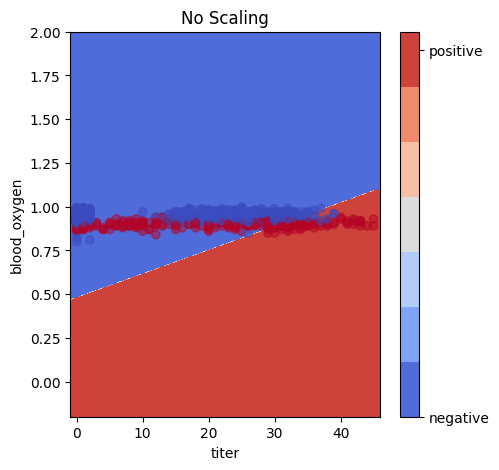

In [14]:
classifier = sklearn.linear_model.LogisticRegression()

# Note that we are using the raw data from `covid_data`,
# and not the scaled data from `covid_features`.
two_features = covid_data[['titer', 'blood_oxygen']]

accuracy = fit_and_visualize_decision_boundary(classifier, two_features, covid_labels, 'No Scaling')
print("Accuracy without scaling: ", accuracy)

Now we can do the same thing, but this time use a pipeline that scales the features instead of just a classifier.

Accuracy without scaling:  0.9816


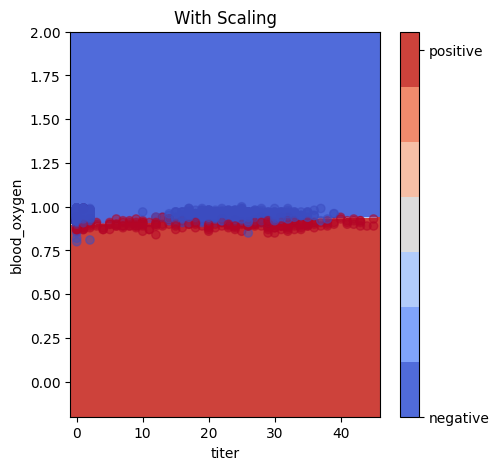

In [15]:
pipeline = sklearn.pipeline.Pipeline([
    ('Scale Features', sklearn.preprocessing.StandardScaler()),
    ('Predict', sklearn.linear_model.LogisticRegression()),
])

# Note that we are using the raw data from `covid_data`,
# and not the scaled data from `covid_features`.
two_features = covid_data[['titer', 'blood_oxygen']]

accuracy = fit_and_visualize_decision_boundary(pipeline, two_features, covid_labels, 'With Scaling')
print("Accuracy without scaling: ", accuracy)

We were able to use en entire pipeline in place of a classifier because it uses the same `fit()`/`predict()` methods.
Note how we got a higher accuracy and see a different decision boundary with the scaled data.

### Test-Train Splits

Up until this point, we have mentioned or hinted at the need to set some data aside to test on after we train our machine learning model.
In this section, we will finally explicitly discuss this concept.

Before we jump into the details, let's imagine a situation that shows why we need to split up our data.
Imagine we make a classifier that just remembers every single data point it has ever seen.
So on `fit()`, all it does is store each data point along with its label.
Then when it comes time to predict, the classifier will just look to see if it has seen the point before.
If it has seen the point it returns the real label,
and if it has not seen the point it returns a random label.

If we train this classifier with `covid_features` like we have with the classifiers we have been working with earlier in this assignment,
then this classifier will always score 100% (since it has seen every single point).
But as soon as we ask the classifier to predict on new data,
it will just give random predictions.
So in testing it will do perfect, but in the real world it will perform poorly.

In this case it is easy to see that our classifier will never work in the real world,
but it is easy to [unintentionally make models that memorize data points](https://bair.berkeley.edu/blog/2019/08/13/memorization/)
(especially if you are using neural networks).
So to help avoid this, we split our data into multiple non-overlapping parts: [train and test](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets).
The *train dataset* (also called "train set", "train split", or just "train") is the data that we will use to train/fit our models.
We can also compute our evaluation metrics (e.g. accuracy) on our train split,
but the resulting score is just used for debugging purposes.
The *test dataset* (also called "test set", "test split", or just "test") is the data that we will officially compute our evaluation metrics on.
The test set should never be used for any training purposes and should remain secret until your model is ready to be evaluated.
It is considered cheating if information "leaks" between the two data splits.

<center><img src="predictive_models.png" width="500px"/></center>
<center style='font-size: small'>Comic courtesy of <a href='https://xkcd.com/2169/'>xkcd</a>.</center>
<center style='font-size: small'>When you don't split your data properly, you may unknowingly leak information.</center>

Sometimes, you may even need a third split of data.
This third split is called the *validation dataset* (also called "validation set", "validation split", or just "validation").
We won't be going into the details of what the validation split is used for,
but (if it exists) it is generally the same size as the test split and used to train [hyperparameters](https://en.wikipedia.org/wiki/Hyperparameter).
Hyperparameters are options that are at a higher level than normal model parameters
(like the option of which machine learning model to use).

There is no exact number or percent that decides how much of your data should be in train vs test.
It just depends on your domain and how much data you have available.
If there are no special circumstances, putting aside 10% - 25% of your data for testing typically works well.

sklearn has a very simple function available that will split data for you:
[sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
If you have more complex data, splitting by hand should is fairly straightforward
(just make sure you don't with skip data points or double include them in both splits).

For example, we may decide to hold out 20% of our Covid-19 data for our test set:

In [16]:
# Broken up over two lines just because the lines are really long.
splits = sklearn.model_selection.train_test_split(covid_features, covid_labels, test_size = 0.20)
covid_features_train, covid_features_test, covid_labels_train, covid_labels_test = splits

# Make sure the sizes match up.
assert len(covid_features_train) == len(covid_labels_train)
assert len(covid_features_test) == len(covid_labels_test)

print("Got %d train data points." % (len(covid_features_train)))
print("Got %d test data points." % (len(covid_features_test)))

Got 4000 train data points.
Got 1000 test data points.


<h3 style="color: darkorange; font-size: x-large";>★ Task 1.B</h3>

Complete the function below that takes in some data (as a dict) and the maximum percentage of the passed in data that should be in the test set.
The function should split the passed in data into train and test sets and return them.

Both train and test should be formatted as a dict that matches the passed in data
(columns names are the keys and the values are the column values).

Truncate when computing the exact number of test records.
For example if there are 5 records and `test_percentage = 0.5`, then the test set should have 2 records in it.
In the cases the `test_percentage` is too low or high,
the test set should always have at least one record and at most all except one record
(the train set also needs to have at least one record).

You may shuffle the resulting splits if you so choose, it will not affect scoring.

Note how [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
does not work right away here, since your data is formatted differently.
Sometimes you may have to either split your data yourself,
or convert it into a format that sklearn.model_selection.train_test_split() understands.

In [17]:
def split_dict_data(data, test_percentage):
    """
    Split the passed in data.

    Args:
        data: The data to split.
            It is a dict with column names as keys and column contents as values.
        test_percentage: The float percentage of data that should be put into the test split.

    Returns:
        The training data in the same dict structure as the passed in data.
        The test data in the same dict structure as the passed in data.
    """
    train = {}
    test = {}
    for key, val in data.items():
        test[key] = val[:int(len(val) * test_percentage)]
        train[key] = [x for x in data[key] if x not in test[key]]
        if len(train[key]) == len(data[key]):
            y = train[key].pop(0)
            test[key].append(y)
    return train, test

data = {
    'people': ["Susan", "Robin", "Avery", "Jacob", "May"],
    'pets': ["ostrich", "iguana", "eagle", "dog", "rock"],
    'music': ["rap", "psychedelic", "country", "metal", "rock"],
}

train, test = split_dict_data(data, test_percentage = 0.5)
print("Train Data: ", train)
print("Test Data: ", test)

Train Data:  {'people': ['Avery', 'Jacob', 'May'], 'pets': ['eagle', 'dog', 'rock'], 'music': ['country', 'metal', 'rock']}
Test Data:  {'people': ['Susan', 'Robin'], 'pets': ['ostrich', 'iguana'], 'music': ['rap', 'psychedelic']}


# Part 2: Linear Models and Regularization

Now that we have taken a quick tour through scikit-learn,
let's dive into the theory of the models we have been using.
In this section, we will look into linear models and the basic tools we use to train them.

Concepts will will explore in this part:
 - Linear Models
 - Loss Functions
 - Gradient Descent
 - Regularization

## Linear Models

[Linear models](https://scikit-learn.org/stable/modules/linear_model.html)
are some of the most common machine learning models to use in practice because they are generally fast, reliable, and easy to interpret.
(The linear models we will be discussing are binary by nature (only predict True/False),
but as we have discussed earlier any binary classifier can be converted into a multiclass classifier.)

Linear models are characterized by using a linear combination of a data point's features to predict a label:

$$
\hat{y}(x, b, w) = b + w_1 x_1 + ... + w_p x_p
$$

Where:
 - $ \hat{y} $ is the predicted label.
 - $ x $ is the features for a single data point.
 - $ b $ is called a "bias", and is any real number.
 - $ w $ is a vector of weights (also real numbers), one for each feature.
   (In different notations, the bias is sometimes included in $ w $ as $ w_0 $.)

Together, we refer to the weights and bias as the "parameters" of the model,
and use the symbol $ \theta $ to represent them.
Notice that the weighted sum can also be written as a dot product:

$$
\hat{y}(x, b, w) = b + w \cdot x
$$

What this equation is saying, is that a linear model wants to predict a label $ \hat{y} $
by adding together the weighted sum of each feature and the bias.
Then a classifier can interpret the result by saying that the more positive this weighted sum is,
the more positive label it (and negative values mean a negative label).

For example, consider the following data about students studying for a class.

| Student | Passes Class (label) | Hours Studied | Taken Class Before |
|---------|----------------------|---------------|--------------------|
| Alice   | True                 | 40            | False              |
| Bob     | True                 | 10            | True               |
| Claire  | False                | 10            | False              |

Now let's do some feature scaling and replace True/False with 1/-1).

| Student | Passes Class (label) | Hours Studied | Taken Class Before |
|---------|----------------------|---------------|--------------------|
| Alice   |  1                   |  1.4          | -1                 |
| Bob     |  1                   | -0.7          |  1                 |
| Claire  | -1                   | -0.7          | -1                 |

Assuming a bias $ b = 0.0 $ and weights $ w = [1.0, 1.0] $,
we will get the following predicted values.

$$
\begin{align}
    \hat{y}_{alice}  & = 0.0 + 1.0 * \ \ \ 1.4 + 1.0 *      -1.0 & = \ \ \ 1.4 - 1.0 & = \mathbf{ \ \ \ 0.4} \\
    \hat{y}_{bob}    & = 0.0 + 1.0 *      -0.7 + 1.0 * \ \ \ 1.0 & =      -0.7 + 1.0 & = \mathbf{ \ \ \ 0.3} \\
    \hat{y}_{claire} & = 0.0 + 1.0 *      -0.7 + 1.0 *      -1.0 & =      -0.7 - 1.0 & = \mathbf{      -1.7} \\
\end{align}
$$

Here we can see (even with our dummy weights) that data points with a positive label (Alice and Bob) will get a positive value,
while Claire gets a negative value.
(If we set $ b $ to $ 0.7 $, then we would have an almost perfect classifier.)
With these values, the classifier can set a threshold (recall the thresholds from HO2).
For simplicity, let the threshold for this example be $ 0.0 $.
So all positive values get assigned to the positive class, and other values get assigned to the negative class.

Even with this simple example we can see one of the strengths of linear models,
they are easy to interpret.
To interpret how a linear model makes decisions, we just have to look at the weights.
The sign of the weight tells us which class the feature favors.
In our example both feature weights (not the bias) are positive,
so the weights favor more studying and taking the class before.
Then, weights with low magnitude means the feature **is not** very important,
and weights with high magnitude means the feature **is** very important.

Normally, we would have to learn the parameters, $ \theta $, (bias and weights) for a model from training data
(remember the thresholds from HO2).
This is the job of training/fitting.
In this example, we just manually selected the parameters.

### Logistic Regression

A class of models that extend linear models are [general linear model](https://en.wikipedia.org/wiki/General_linear_model).
The main difference with general linear models is that they apply a function to the linear combination before making a prediction:

$$
\hat{y}(x, b, w) = f( b + w \cdot x )
$$

It may seem like a simple change, but it allows for much more flexibility when creating models.

On of the most popular and effective linear models is [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression).
We have used a logistic regression classifier multiple times in this assignment,
but we have not yet discussed the theory behind it.
Logistic regression is a general linear model that applies the [logistic function](https://en.wikipedia.org/wiki/Logistic_function) to the linear combination.
(The logistic function is sometimes also called the "sigmoid", "expit", or "inverse logit" function.)
The equation for the standard logistic function is bellow:

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

The interesting thing about the logistic function is that is tends to produce values that are close to either $ 0.0 $ or $ 1.0 $.

<center><img src="logistic.png" style="background-color: white" width="500px"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:Logistic-curve.svg'>Wikimedia Commons</a>.</center>

This makes it ideal for a binary classifier where $ 0.0 $ can represent the negative class, and $ 1.0 $ can represent the positive class.
Then our logistic regression classifier can set the classification threshold to $ 0.5 $.

### Loss Functions

As mentioned earlier,
when we fit/train a linear classifier we are really just figuring out the best values for the bias and feature weights.
Like in HO2, if we want to train a model, we need a loss function.
Recall that a loss function tells us how well our model is performing.
Unlike in HO2 where we were just setting a single threshold value (and could therefore use a brute force approach),
we now need to set a bias and weight for each feature.

There are [many different known loss functions](https://en.wikipedia.org/wiki/Loss_functions_for_classification) that we can choose from.
One of the most common types of loss is [cross-entropy](https://en.wikipedia.org/wiki/Cross_entropy),
also commonly referred to as "log loss" or "logistic loss".

The equation for cross-entropy loss is:
$$
L_\text{logistic}(X, Y, \theta) = - \sum_{y} \Pr(Y = y | x, \theta) \log \big( \Pr(\hat{Y} = y | x, \theta) \big)
$$

If we let our labels be $ 0 $ and $ 1 $, then we can write it as:
$$
L_\text{logistic}(X, Y, \theta) = - \sum_{i = 1}^{|Y|} \bigg[ y_i \log \big( \Pr(\hat{y}_i = 1 | x_i, \theta) \big) + (1 - y_i) \log \big( \Pr(\hat{y}_i = 0 | x_i, \theta) \big) \bigg]
$$

This equation may look complex, but we can break it into smaller pieces to see what it is doing.

First, we can see that it is summing from $ i = 1 $ to $ |Y| $,
so that means it is just summing over every data point.

Next, we can see that there are two different parts to the sum, joined by addition:

$$
\begin{align}
    y_i       &*  \log \big( \Pr(\hat{y}_i = 1 | x_i, \theta) \big) \\
    (1 - y_i) &*  \log \big( \Pr(\hat{y}_i = 0 | x_i, \theta) \big) \\
\end{align}
$$

Notice how one term starts with a $ y_i $ and the other starts with a $ (1 - y_i) $.
Since we said earlier that we are setting out labels to either $ 0 $ and $ 1 $,
when one of these terms is multiplied by $ 1 $ the other must be multiplied by $ 0 $.
Therefore, depending on the actual label, $ y_i $, only one of these terms is active.
Specifically, the term that corresponds to the correct label is activated
(when $ y_i $ is 1 (positive label) the term with $ \Pr(\hat{y}_i = 1 | x_i, \theta) $ is active and vice versa).

If the label is true ($ 1 $), then the top term is active and can be simplified to:

$$
\log \big( \Pr(\hat{y}_i = 1 | x_i, \theta) \big)
$$

Which is just the logarithm of the probability that $ y_i $ is 1 (true).

So in the end, all we need to do to compute the cross-entropy (logistic) loss is to
find the probabilities of predicting each data point correctly,
take the logarithm of those probabilities,
sum them,
and negate the sum.

(
If you are having trouble parsing equations, then try to take the approach we went through above.
Understanding equations can be hard, so just take your time and try to figure out what each piece of the equation is trying to do.
Then see if you can piece it together and figure out what the goal of the equation is.
)

Now we have a mathematical model for our classifier and a loss function,
but how actually do the training?

## Gradient Descent (GD)

To train our classifier (learn $ \theta $ ($ w $ and $ b $ for a linear model)),
we need to be able to minimize the loss function.
For example, we may need to solve (choose the $ \theta $ that minimizes the loss):

$$
\underset{\theta}{\mathrm{argmin}} \ L_\text{logistic}(X, Y, \theta)
$$

One of the simplest and most effective means of training machine learning models is with
[gradient descent](https://en.wikipedia.org/wiki/Gradient_descent).
The main idea behind gradient descent is simple,
use the gradient of the loss to point us in the right direction and take a small step in that direction.
We can slowly move our parameters (weights and bias) to follow the local gradients to find a local minima for loss.

Intuitively, we can think of gradient descent as sliding downhill in the steepest possible direction,
as in the below image.

<center><img src="gradient_descent.gif" style="background-color: white" width="500px"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://angeloyeo.github.io/2020/08/16/gradient_descent.html'>angeloyeo.github.io</a>.</center>

You may be wondering why we take many small steps instead of just solving the minimization in one step
(like you may have done in a calculus class).
If we know what the exact form of your loss function (which you will not always know)
and it has a closed and differentiable form (which it will not always),
then it can be tempting to just solve it directly.
But remember that we are not typically working with loss functions that have only one or two variables.
The Covid-19 data we are using has 9 dimensions, and it is considered very small.
In real world scenarios you can easily have hundreds, thousands, or even more dimensions.
So it is usually faster to solve iteratively using something like gradient descent instead of directly.
(However, sometimes we can take shortcuts by using insights from a loss' closed form.)

Gradient descent is simple, but has shown to be very powerful for machine learning.
Many of the most effective fitting algorithms we use today are based on gradient descent.
Of those, [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) (SGD)
is probably the most successful variant (that has spawned its own family of derived methods).
We will not go into detail of SGD in this assignment,
but we will mention it since you will be using it in this assignment
(and are likely to run into it in the wild).
Instead of looking at all points at once, SGD chooses a random batch of data points and just computes a gradient over them.
It would seem like working with less points at a time would be worse, but SGD is almost always better.

Of course, sklearn has its own SGD-based classifier that we can use:
[sklearn.linear_model.SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html).

Accuracy:  0.9824


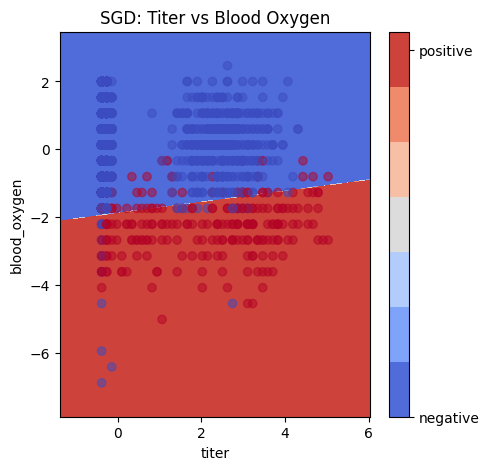

In [18]:
# Make an SGD classifier.
classifier = sklearn.linear_model.SGDClassifier()

two_features = covid_features[['titer', 'blood_oxygen']]

classifier.fit(two_features, covid_labels)
visualize_decision_boundary(classifier, two_features, covid_labels, "SGD: Titer vs Blood Oxygen")

print("Accuracy: ", classifier.score(two_features, covid_labels))

### Experiments with Different Loss Functions

Now, we want to explore different loss functions and see how they will perform.
We don't have enough time to go into detail of them all,
but we can at least take a quick look at how they generate different decision boundaries.
However, this is hard to do with our Covid-19 dataset
because of the number of data points and complexity of the data.
So instead, let's make some simple synthetic classification data using sklearn's
[sklearn.datasets.make_classification](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function.

In [19]:
def make_toy_data(size):
    features, labels = sklearn.datasets.make_classification(
        n_samples = size, n_features = 2,
        n_informative = 2, n_redundant = 0, n_repeated = 0,
        random_state = 0,
    )

    column1, column2 = zip(features.transpose())

    features = pandas.DataFrame.from_dict({"a": column1[0], "b": column2[0]})
    labels = pandas.Series(labels)

    return features, labels

toy_features, toy_labels = make_toy_data(15)
toy_features

,a,b
0,0.210310,-2.052905
1,-0.658608,0.372155
2,-0.101889,1.878826
3,-0.903850,1.230913
4,0.773254,-1.439241
5,1.133944,-0.999534
6,-0.761029,-0.926300
7,-0.458016,1.369615
8,-0.713266,0.723475
9,0.823593,1.143363


Let's make a simple function to test out an SGD classifier with different loss functions.

In [20]:
def sgd_with_loss(features, labels, loss):
    classifier = sklearn.linear_model.SGDClassifier(loss = loss, penalty = None,
                                                    max_iter = 100, random_state = 0)

    title = "SGD with %s Loss" % (loss)
    accuracy = fit_and_visualize_decision_boundary(classifier, features, labels, title)

    print("Accuracy for %s loss: %f." % (loss, accuracy))

Now that we have some simple data and a testing function,
we can see how different loss functions create different classifiers (and decision boundaries).

We have already discussed cross-entropy loss in this assignment,
and you have already discussed L1 and L2 losses in class.
Below, we will invoke several different loss function that you are not responsible for learning.
By looking at the different decision boundaries created by these different loss functions,
we hope to show you how different parameters of a classifier (the loss function in this case) can create very different decision boundaries.
And even though the decision boundaries may be different, they may still result in similar scores in the end.
If do you want to read about the details of each loss function,
you can start with the [sklearn loss documentation](https://scikit-learn.org/stable/modules/sgd.html#sgd-mathematical-formulation).

Accuracy for log_loss loss: 0.866667.


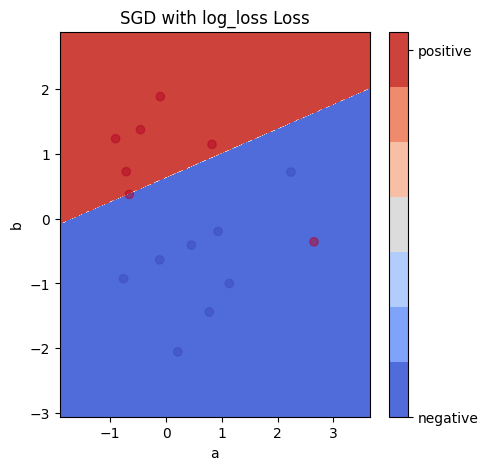

In [21]:
sgd_with_loss(toy_features, toy_labels, 'log_loss')

We have already seen `log_loss` once before.
Notice here that this classifier only achieved an accuracy of 0.87,
so that one red point on the decision boundary actually falls on the blue side and is misclassified.

Accuracy for hinge loss: 0.866667.


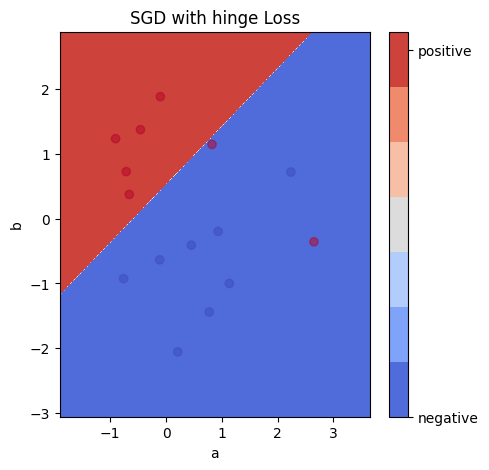

In [22]:
sgd_with_loss(toy_features, toy_labels, 'hinge')

Using the `hinge` loss we see the same accuracy as the `log_loss`,
but a different decision boundary is created.
This one is steeper and misclassifies a different red point.

Accuracy for perceptron loss: 0.800000.


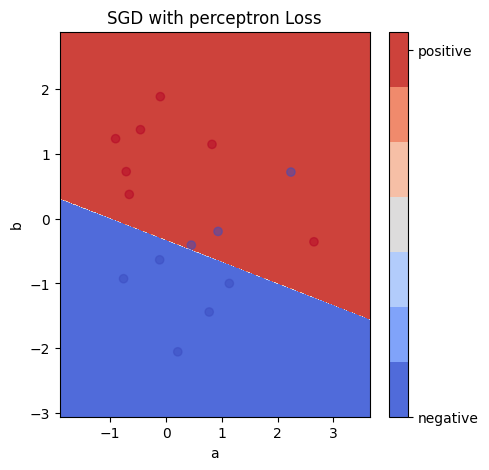

In [23]:
sgd_with_loss(toy_features, toy_labels, 'perceptron')

Here we can see the `perceptron` loss performed significantly worse
and chose a very different decision boundary from the other loss functions.
In this case, our classifier produced no false positives.

Accuracy for modified_huber loss: 0.800000.


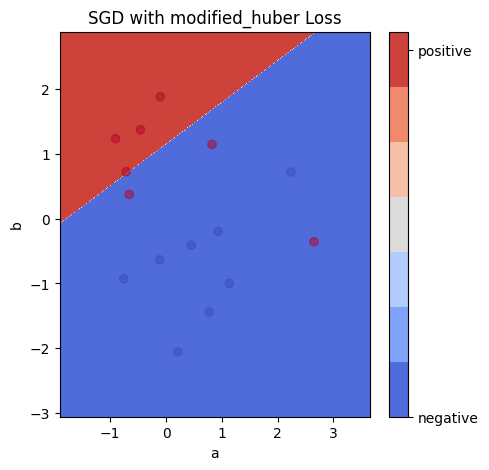

In [24]:
sgd_with_loss(toy_features, toy_labels, 'modified_huber')

The `modified_huber` loss performed just as poorly as the `perceptron` loss in this case,
but found a very different decision boundary.

Accuracy for squared_hinge loss: 0.933333.


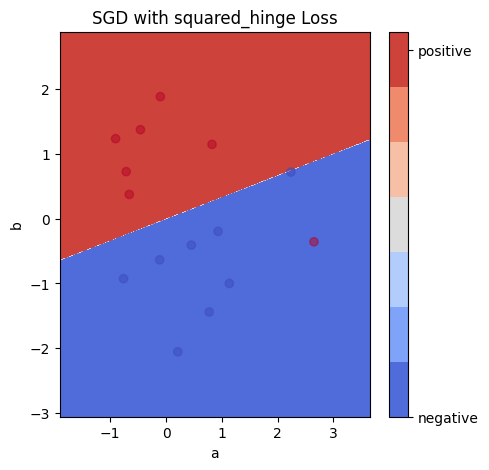

In [25]:
sgd_with_loss(toy_features, toy_labels, 'squared_hinge')

The `squared_hinge` loss seems to perform the best in this case,
only misclassifying one point.

Note that we have not explored these different loss functions enough to draw any conclusions or intuitions.
However, we can see that different loss functions do affect how a classifier performs.

## Regularization

What happens when we are trying to train a classifier,
but there are many different parameters that give the same loss?
Think back to our student studying example.
We choose the $ w = [1.0, 1.0 ] $,
but what if we instead used $ w = [100.0, 100.0 ] $?
We would end up with the same loss (zero because we classified everything perfectly),
but we would end up with weights that are 100 times larger in magnitude.
Which weights should our classifier prefer, $ 1.0 $ or $ 100.0 $?

To decide cases like this, we use [regularization](https://en.wikipedia.org/wiki/Regularization_(mathematics)).
Regularization can be used for a variety of situations,
the most common ones is to punish models for being too complex and enforce constraints.
In this assignment, we will cover the former (punishing complex models).

We we talk about "complex" linear models, we usually mean models with many large (and non-zero) weights.
In terms of complexity, nothing is simpler than nothing,
so we can use regularization to tell our model to prefer weights closer to zero.
This would mean that we would like our model to ignore features that are not very useful.
(We may even be able to remove these features from out data if we see them consistently getting zero (or close to zero) weights).

The most simple regularizer is the [L1 norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Taxicab_norm_or_Manhattan_norm)
(also called the "Taxicab" or "Manhattan" norm).
The L1 norm of $ \theta $ (written as $ || \theta ||_1 $) is just sums the absolute value of $ \theta $
(which is also the [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry) between the origin and $ \theta $).

$$
|| \theta ||_1 = \sum_i | \theta_i |
$$

We can just add our regularizer to our loss to create our new regularized/total loss
(along with an $ \alpha $ hyperparameter that controls how influential the regularizer is):

$$
L_\text{total}(X, Y, \theta) = L_\text{logistic}(X, Y, \theta) + \alpha || \theta ||_1
$$

Now if we consider our student example again,
we can see that we will get different losses because of the regularizer:

$$
\begin{align}
    L_\text{total}(X, Y, \theta = {b = 0.0, w = [1.0,   1.0  ]}) & = 0.0 + || \theta ||_1 & = |0.0| + |1.0|   + |1.0|   & = \mathbf{2.0}   \\
    L_\text{total}(X, Y, \theta = {b = 0.0, w = [100.0, 100.0]}) & = 0.0 + || \theta ||_1 & = |0.0| + |100.0| + |100.0| & = \mathbf{200.0} \\
\end{align}
$$

It is clear that with our regularizer, the lower weights are preferred (have a lower loss).


Probably the most popular norm and sibling of the L1 norm is the [L2 norm](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm)
(also called the "Euclidean" norm).
The L2 norm of $ \theta $ (written as $ || \theta ||_2 $) is the square root of the sum of squares of $ \theta $
(which is also the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the origin and $ \theta $).

$$
|| \theta ||_2 = \sqrt{\sum_i \theta_i^2}
$$

Accuracy for l1 regularizer: 0.866667.


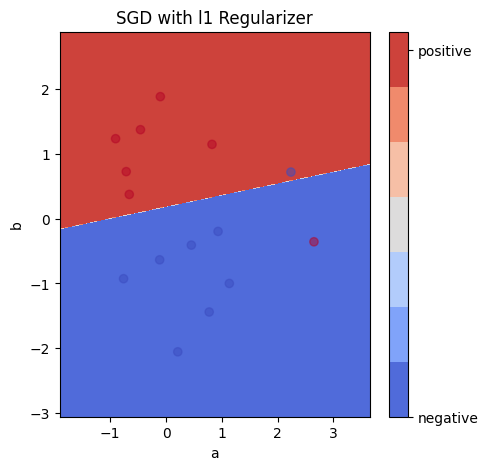

In [26]:
regularizer = 'l1'

# Make an SGD classifier with an L1 penalty and 0.1 alpha.
classifier = sklearn.linear_model.SGDClassifier(loss = 'hinge',
                                                penalty = regularizer, alpha = 0.1,
                                                max_iter = 100, random_state = 1)

title = "SGD with %s Regularizer" % (regularizer)
accuracy = fit_and_visualize_decision_boundary(classifier, toy_features, toy_labels, title)

print("Accuracy for %s regularizer: %f." % (regularizer, accuracy))

Using the L1 regularizer produced a different decision boundary than in our previous test with the `hinge` loss,
but gets the same accuracy.

Accuracy for l2 regularizer: 0.933333.


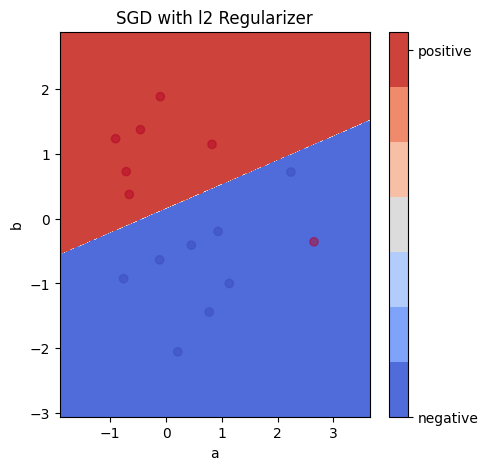

In [27]:
regularizer = 'l2'

# Make an SGD classifier with an L1 penalty and 0.1 alpha.
classifier = sklearn.linear_model.SGDClassifier(loss = 'hinge',
                                                penalty = regularizer, alpha = 0.1,
                                                max_iter = 100, random_state = 1)

title = "SGD with %s Regularizer" % (regularizer)
accuracy = fit_and_visualize_decision_boundary(classifier, toy_features, toy_labels, title)

print("Accuracy for %s regularizer: %f." % (regularizer, accuracy))

Using the L2 regularizer gives a boost to our accuracy in this case.

# Part 3: Non-Linear Models

All the classifiers we have used so far in this assignment have been linear models, i.e.,
they create a linear decision boundary.

The simplicity of linear models make them fast to train and easy to interpret.
But, their simplicity also means there will be some data sets that are impossible to correctly classify.
Take another look at the toy data set we used in the last part.
No matter how we orient our decision boundary,
it is impossible to separate all the blue and red points.

Non-linear models flip the pros and cons of linear models.
Non-linear models may be more complex and therefore more computationally costly and harder to interpret,
but a non-linear decision boundary can split data that could not be cleanly split with a linear decision boundary.

In this part, we will discuss a few non-linear machine learning models:
 - [Decision Trees](https://en.wikipedia.org/wiki/Decision_tree_learning)
 - [K-Nearest Neighbors (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

## Decision Trees

[Decision trees](https://en.wikipedia.org/wiki/Decision_tree) are a class of models that attempt to create a tree
where each non-leaf node splits the data (usually based on a single feature).
For example, consider the following decision tree that predicts whether a passenger on the Titanic survived its sinking.

<center><img src="decision_tree.jpg" style="background-color: white" width="500px"/></center>
<center style='font-size: small'>
    A tree showing survival of passengers on the Titanic
    ("sibsp" is the number of spouses or siblings aboard).
    <br />
    The figures under the leaves show the probability of survival and the percentage of observations in the leaf.
    <br />
    Summarizing: Your chances of survival were good if you were (i) a female or (ii) a male at most 9.5 years old with strictly fewer than 3 siblings.
</center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:Decision_Tree.jpg'>Wikimedia Commons</a>.</center>

Although this tree only makes binary splits and uses a single variable at a time,
it is possible to create trees that have nodes with more than two children
and nodes that consider more than one feature at a time.

The biggest benefit of decision tress is that they are interpretable (as long as the tree is relatively small).
Decision trees are a natural way for people to process data,
and are even used outside of machine learning to help normal non-electric humans make decisions.
Some drawbacks of decision trees is that they are sensitive to changes in the data
(small changes in the data can result in generating entirely different trees)
and they can be much harder to learn than linear models.

A common way to use decision tree is to create several tress and combine them into a [random forest](https://en.wikipedia.org/wiki/Random_forest).
Random forests are an [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning) technique that has multiple decision trees
that all get to vote on what the prediction should be.
Using multiple trees allows different parameters (or even algorithms) to be used to generate each tree,
so the overall models gets to look at the data in several different ways.

<center><img src="random_forest.png" style="background-color: white" width="500px"/></center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:Random_forest_diagram_complete.png'>Wikimedia Commons</a>.</center>

Let's try using a decision tree to classify our toy data.

Accuracy: 1.000000.


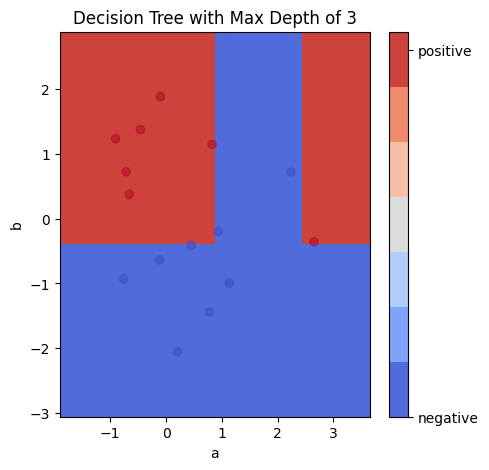

In [28]:
# Make a decision tree classifier a max depth of 3.
decision_tree = sklearn.tree.DecisionTreeClassifier(max_depth = 3, random_state = 0)

title = "Decision Tree with Max Depth of 3"
accuracy = fit_and_visualize_decision_boundary(decision_tree, toy_features, toy_labels, title)

print("Accuracy: %f." % (accuracy))

In addition to visualizing the decision boundary of this tree,
we can also visualize the tree itself.
Child nodes on the left represent data points where the condition in the parent node is true,
while child nodes on the right represent data points where the condition in the parent is false.

[Text(0.3333333333333333, 0.875, 'b <= -0.383\nsamples = 15\nvalue = [8, 7]\nclass = 0'),
 Text(0.16666666666666666, 0.625, 'samples = 6\nvalue = [6, 0]\nclass = 0'),
 Text(0.5, 0.625, 'a <= 0.878\nsamples = 9\nvalue = [2, 7]\nclass = 1'),
 Text(0.3333333333333333, 0.375, 'samples = 6\nvalue = [0, 6]\nclass = 1'),
 Text(0.6666666666666666, 0.375, 'a <= 2.444\nsamples = 3\nvalue = [2, 1]\nclass = 0'),
 Text(0.5, 0.125, 'samples = 2\nvalue = [2, 0]\nclass = 0'),
 Text(0.8333333333333334, 0.125, 'samples = 1\nvalue = [0, 1]\nclass = 1')]

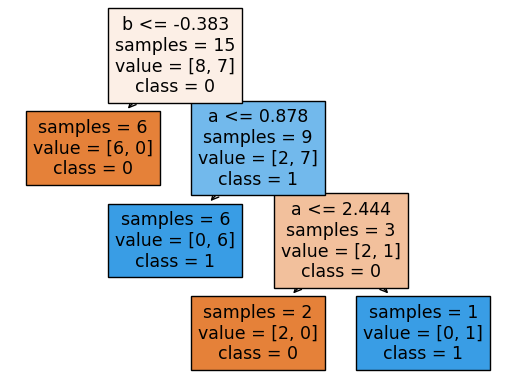

In [29]:
sklearn.tree.plot_tree(decision_tree, feature_names = ['a', 'b'], class_names = ['0', '1'],
                       filled = True, impurity = False)

<h3 style="color: darkorange; font-size: x-large";>★ Task 3.A</h3>

Complete the function below, which re-implements the same decision tree as above using if statements.
The function's argument are the features for a single data point,
and the function should return 0 or 1 (as shown in the above tree).

In [30]:
def manual_decision_tree(features):
    """
    Manually re-create a decision tree.

    Args:
        features: A list of floats that represents the features for a single data point.

    Returns:
        The prdeicted label as an int.
    """
    if features[1] <= -0.383:
        return 0
    if features[0] <= 0.878:
        return 1
    if features[0] <= 2.444:
        return 0
    else:
        return 1

test_point = [0.0, 0.0]
print("Label of test point (%s): %s" % (test_point, manual_decision_tree(test_point)))

Label of test point ([0.0, 0.0]): 1


## K-Nearest Neighbors (KNN)

Our next non-linear model is [K-Nearest Neighbors (KNN)](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm).
KNN is a very simple an intuitive model.
During training, KNN just remembers the data points and labels provided.
Then for each data point KNN is to make a prediction for,
the classifier finds the K nearest training data points
and predicts the most common label amongst those nearest labels.

The following diagram shows an example of KNN.

<center><img src="knn.png" style="background-color: white" width="500px"/></center>
<center style='font-size: small'>
    Example of k-NN classification.
    <br />
    The test sample (green dot) should be classified either to blue squares or to red triangles.
    <br />
    If k = 3 (solid line circle) it is assigned to the red triangles because there are 2 triangles and only 1 square inside the inner circle.
    <br />
    If k = 5 (dashed line circle) it is assigned to the blue squares (3 squares vs. 2 triangles inside the outer circle).
</center>
<center style='font-size: small'>Image courtesy of <a href='https://en.wikipedia.org/wiki/File:KnnClassification.svg'>Wikimedia Commons</a>.</center>

The benefits of KNN is that it is
fast to train (it just needs to store the data points);
lazy (it only does computation work when it actually needs to, like any good Computer Science student);
and easy to interpret (to explain why a prediction is made, KNN just needs to provide the similar training data points).

The drawbacks of KNN is that it
has to search against all known data points when making predictions (smart implementation can do some pre-computation to minimize this time, but many comparisons must still be made);
runs into trouble if the class labels are imbalanced;
and uses much more memory than most models (KNN needs to store all training data, but linear models only need to store a bias and weights).

Let visualize a KNN classifier where K = 1 (a 1-NN classifier),
which classifies new data using the same label as the closest point to it in the training set.

Accuracy: 1.000000.


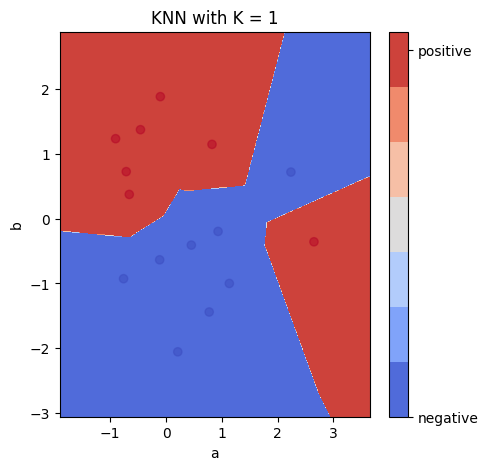

In [31]:
# Make a KNN classifier with a K of 1.
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 1)

title = "KNN with K = 1"
accuracy = fit_and_visualize_decision_boundary(classifier, toy_features, toy_labels, title)

# Accuracy will always be 100% since we are memorizing all the data points.
print("Accuracy: %f." % (accuracy))

Of course our 1-NN classifier gets 100% accuracy, since it memorized all the training data (and we are not splitting our toy data).
If we use our Covid-19 splits we can see KNN getting the expected 100% accuracy when scored on the train data,
and a lower score on the test data.

In [32]:
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 1)
classifier.fit(covid_features_train, covid_labels_train)

print("Train Score: ", classifier.score(covid_features_train, covid_labels_train))
print("Test Score: ", classifier.score(covid_features_test, covid_labels_test))

Train Score:  1.0
Test Score:  0.97


What does our decision boundary look like if we revisit the toy data with a K of 3?

Accuracy: 1.000000.


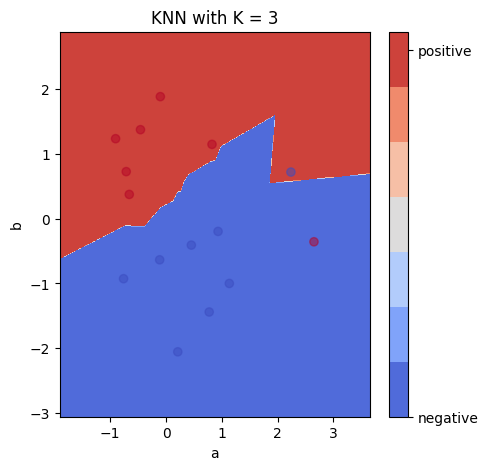

In [33]:
# Make a KNN classifier with a K of 3.
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 3)

title = "KNN with K = 3"
fit_and_visualize_decision_boundary(classifier, toy_features, toy_labels, title)

print("Accuracy: %f." % (accuracy))

With a K of 3, KNN doesn't score 100% on the training data.
Note that this does not mean KNN is doing poorly.
It just means that 1-NN is a special case.

Observe how a 3-NN classifier scores better on the Covid-19 test split.

In [34]:
classifier = sklearn.neighbors.KNeighborsClassifier(n_neighbors = 3)
classifier.fit(covid_features_train, covid_labels_train)

print("Train Score: ", classifier.score(covid_features_train, covid_labels_train))
print("Test Score: ", classifier.score(covid_features_test, covid_labels_test))

Train Score:  0.9885
Test Score:  0.976


<h3 style="color: darkorange; font-size: x-large";>★ Task 3.B</h3>

Complete the class below which implements a KNN classifier (and meets the requirements for being a sklearn predictor).
You only need to complete the `fit()` and `predict()` methods.
You may modify the contents of any methods as you see fit (but not the signatures),
and you may make any other functions you want (but prefix any additional functions with an underscore to avoid conflicts with sklearn).

Details:
 - K will always be less than the number of training points.
 - All features will be numeric.
 - The number of features will be >= 2.
 - Labels can be anything hashable (so they can go in a dict or set).
 - Use euclidean distance to compute distance between points.
 - In the event of a tie, you may choose which of the tied labels to predict.
 - `predict()` must return a numpy.ndarray.
 - You may not use any sklearn functionality aside from the uses already provided (`sklearn.base.BaseEstimator` and `sklearn.metrics.accuracy_score`).

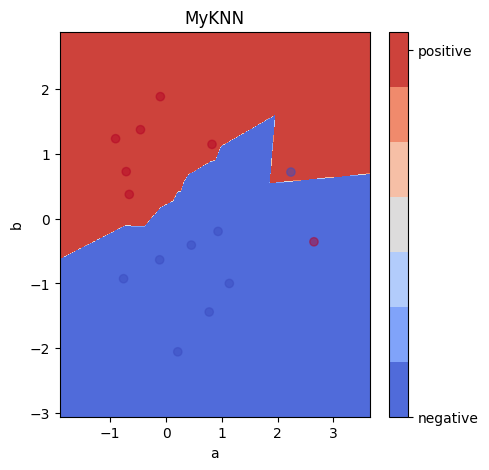

In [38]:
def _distance(p_vals, q_vals):
    sum = 0
    for p, q in zip(p_vals, q_vals):
        sum += (p - q)**2
    return sum**0.5

class MyKNN(sklearn.base.BaseEstimator):
    def __init__(self, k):
        self.k = k
        self.ignore_ = True  # Students can ignore this.

    def fit(self, train_features, train_labels):
        """
        Train the KNN classifier.

        Args:
            train_features: A pandas.DataFrame that only contains numeric data.
            train_labels: A pandas.Series containing the labels.
        """
        self.features = train_features
        self.labels = train_labels
        return self
        
    def predict(self, test_features):
        """
        Make predictions on the passed in data points.

        Args:
            test_features: A pandas.DataFrame that only contains numeric data.

        Returns:
            A numpy.ndarray with the predictions.
        """
        predictions = []
        for test_feature in test_features.values:
            labels_from_dist = {}
            for label, train_feature in zip(self.labels.values, self.features.values):
                dist = _distance(test_feature, train_feature)
                labels_from_dist[dist] = label
            sorted_distances = sorted(labels_from_dist.keys())
            options = {key: 0 for key in self.labels}
            for i in range(min(self.k, len(sorted_distances))):
                options[labels_from_dist[sorted_distances[i]]] += 1
            most_common = sorted(options.values())[-1]
            for key in options.keys():
                if options[key] == most_common:
                    predictions.append(key)
                    break
            '''
            prediction = 0
            for i in range(self.k):
                prediction += labels_from_dist[sorted_distances[i]]
            predictions.append(round(float(prediction) / self.k))
            '''
        return np.array(predictions)

    def score(self, test_features, test_labels):
        predictions = self.predict(test_features)
        return sklearn.metrics.accuracy_score(predictions, test_labels)

classifier = MyKNN(3)
accuracy = fit_and_visualize_decision_boundary(classifier, toy_features, toy_labels, "MyKNN")

# Part 4: Classic Results

A big part of becoming a true data scientist or machine learner is about trying many different things and seeing many different situations.
These efforts help to build the intuition that will guide us as we clean data, create models, and tune parameters.
In this section, we are going to highlight two pieces of machine learning wisdom:
 - More Data Produces Better Models
 - Complex Models May Backfire

## More Data Produces Better Models

As machine learners, data is at the core of everything we do.
So of course, we always want more data.
But does more data actually produce better results?
Generally ... yes it does.
More data gives us more opportunities to see patterns and trends.

It is important to note that we are not just talking about any data.
We always want to see more labeled (so we can train on it)
and trustworthy (so it doesn't trick our models).
We call low quality data "garbage",
and a key tenant of machine learning and data science is:
"Garbage in, garbage out".
This phrase is so important, that is [has it's own Wikipedia page](https://en.wikipedia.org/wiki/Garbage_in,_garbage_out)
(for a phrase!).

In the below cell, we will see how the training and test accuracy change as more and more data points are given in the training set.
We will be specifically looking at a type of graph called a [learning curve](https://en.wikipedia.org/wiki/Learning_curve),
which shows how our model improves over time (or in this case, as more data is provided for training on).

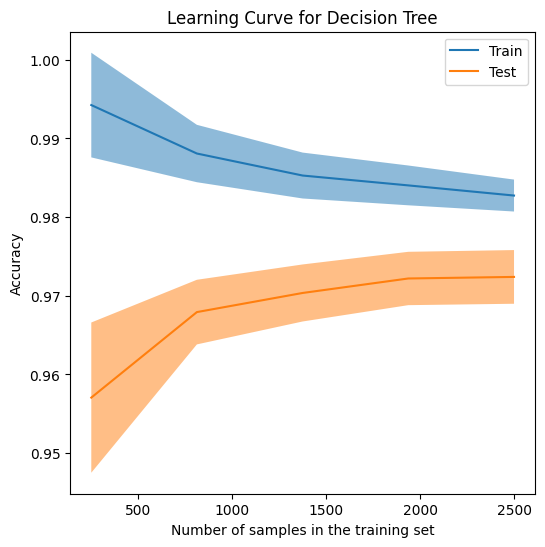

In [36]:
toy_large_features, toy_large_labels = make_toy_data(5000)
classifier = sklearn.tree.DecisionTreeClassifier(max_depth = 5, random_state = 0)

figure, axis = matplotlib.pyplot.subplots(1, 1, figsize = (6, 6))
axis.set_title("Learning Curve for Decision Tree")

sklearn.model_selection.LearningCurveDisplay.from_estimator(
    classifier, toy_large_features, toy_large_labels,
    cv = sklearn.model_selection.ShuffleSplit(n_splits = 50, test_size = 0.5, random_state = 0),
    score_type="both", score_name="Accuracy", ax = axis,
)

We see that as more data is provided,
the training accuracy decreases and then flattens out.
A lower accuracy may seem alarming at first, but this is exactly what we expect to see.
As the training set grows larger,
our model is moving away from memorizing data points and moving towards learning patterns in the data.
These patterns are what can be effectively applied to the test data,
and that is why the test accuracy improves as more training data is provided.

## Complex Models May Backfire

Next, we show increasing the depth of the tree only helps testing accuracy up to a point,
beyond which we [overfit](https://en.wikipedia.org/wiki/Overfitting) on the training data.
Overfitting is a huge challenge, especially with some types of models (like decision trees and neural networks).

A model that has overfit has learned the specific peculiarities of its training data,
rather than the general patterns of any data drawn from the same distribution.
One way to conceptualize overfitting is to think of it as "memorizing the features of noise".
Generally, a model is more able to overfit when it is
- more complex.
- trained for longer.

Below, we show that increasing model complexity (e.g., the depth of a decision tree),
while uniformly associated with higher training accuracy,
ultimately allows overfitting to the training data,
at which point the model cannot generalize to unseen test data
(because it expects it to look too much the training data!).
The best performance on the testing data occurs somewhere between a model that is:
- too simple to learn anything.
- too complex and able to effectively "memorize" its training data.

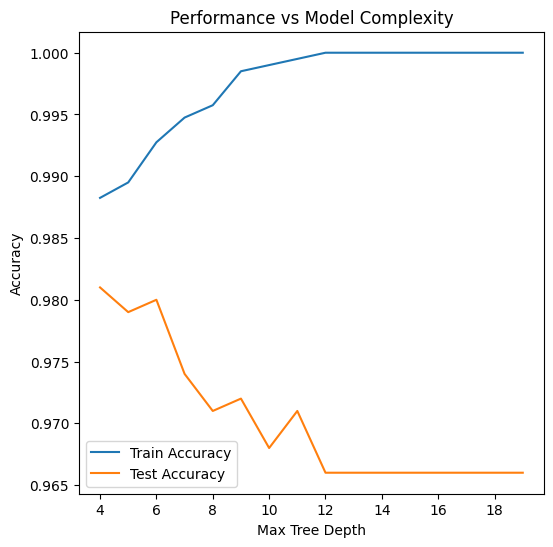

In [37]:
min_tree_depth = 4
max_tree_depth = 20

figure, axis = matplotlib.pyplot.subplots(1, 1, figsize = (6, 6))
axis.set_title("Performance vs Model Complexity")
axis.set_xlabel("Max Tree Depth")
axis.set_ylabel("Accuracy")

max_depths = list(range(min_tree_depth, max_tree_depth))
train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    classifier = sklearn.tree.DecisionTreeClassifier(max_depth = max_depth, random_state = 0)
    classifier.fit(covid_features_train, covid_labels_train)

    train_accuracy = classifier.score(covid_features_train, covid_labels_train)
    test_accuracy = classifier.score(covid_features_test, covid_labels_test)

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

axis.plot(max_depths, train_accuracies, label = "Train Accuracy")
axis.plot(max_depths, test_accuracies, label = "Test Accuracy")
axis.legend()

As our model becomes more complex
(our tree is allowed to become larger),
if first hits a point were the highest test accuracy is achieved.
But instead of flattening out (like we saw in our learning curve graph above),
the overly complex model starts to score worse on the test data.
The training score reaches 100% because the tree has enough complexity to model every point in the training set.